<a href="https://colab.research.google.com/github/vittoriohalfon/GAN-generator/blob/main/GAN_final_gen_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow matplotlib tensorflow-datasets ipywidgets

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# Brining in tensorflow datasets for fashion mnist
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

In [4]:
# Use the tensorflow datasets api to bring in the data source
ds = tfds.load('fashion_mnist', split='train')

In [5]:
ds.as_numpy_iterator().next()['label']

2

In [41]:
## VISUALIZING DATASET
import numpy as np
#Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

In [ ]:
# Getting data out of the pipeline
dataiterator.next()

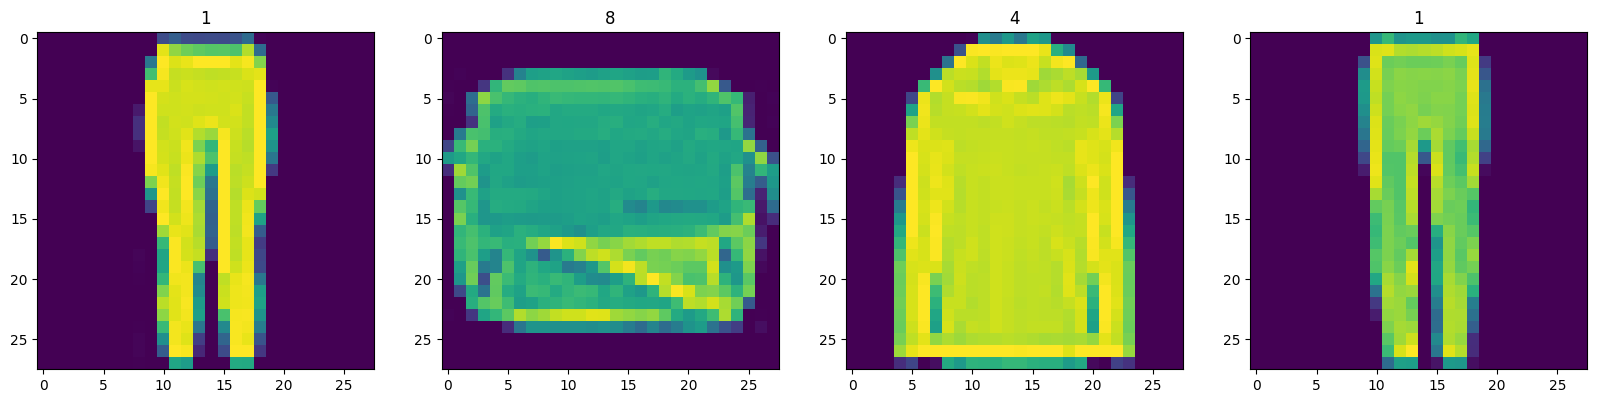

In [8]:
#Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
#Loop 4 times and get images
for idx in range(4):
#Grab an image and label from the dataset iterator
    sample = dataiterator.next()
#Plot the image using a specific axis/subplot
    ax[idx].imshow(np.squeeze(sample['image']))
#Appending the image label as plot title
    ax[idx].title.set_text(sample['label'])

In [42]:
def scale_image(data):
    image = data['image']
    return image / 255

In [10]:
#Reload dataset
ds = tfds.load('fashion_mnist', split='train')
#Apply scaling function to images
ds = ds.map(scale_image)
#Cache dataset for that batch
ds = ds.cache()
#Shuffle dataset
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces likelihood of overfitting
ds = ds.prefetch(64)
# %%
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

**BUILD NEURAL NETWORK**

In [11]:
#Bring in sequential API for generator/discriminator
from tensorflow.keras.models import Sequential
#Bring in layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [44]:
def build_generator():
    model = Sequential()

# Takes in random values and reshapes to 7 x 7 x 128
# Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

# UpSamples to 14 x 14 x 128
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

# UpSamples to 28 x 28 x 128
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

# Convolutional block
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

# Convolutional block
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

# Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model

In [43]:
generator = build_generator()

In [14]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

1/1 [==============================] - 0s 92ms/step


(28, 28, 1)

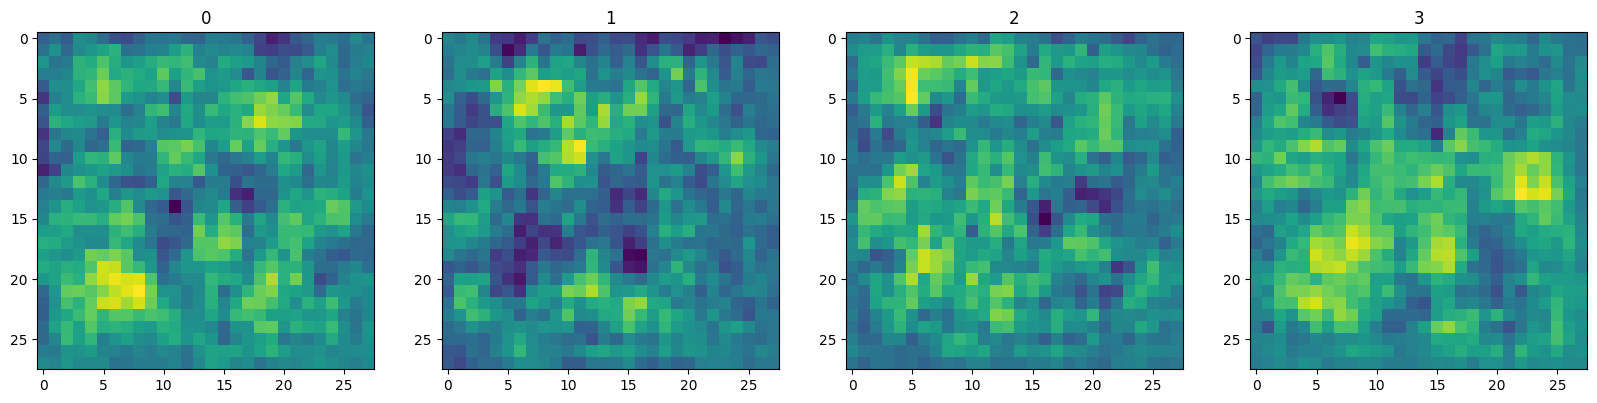

In [45]:
#Generate new fashion
img = generator.predict(np.random.randn(4, 128, 1))
#Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
#Loop 4 times and get images
for idx, img in enumerate(img):
#Plot the image using a specific axis/subplot
    ax[idx].imshow(np.squeeze(img))
#Appending the image label as plot title
    ax[idx].title.set_text(idx)
img.shape

In [46]:
#Build the discriminator
def build_discriminator():
    model = Sequential()

# 1st Convolutional block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

# 2nd Convolutional block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

# 3rd Convolutional block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

# 4th Convolutional block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

# Flatten and output layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [47]:
discriminator = build_discriminator()

In [48]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 128)      

In [19]:
img.shape

(28, 28, 1)

In [20]:
discriminator.predict(np.expand_dims(img,0))  # Predict on the reshaped img array

1/1 [==============================] - 0s 143ms/step


array([[0.49580956]], dtype=float32)

**TRAINING LOOP**

In [21]:
#IMPORTS
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [22]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [23]:
#Importing base model class ti subclass our training step
from tensorflow.keras import Model

In [ ]:
tf.random.normal((6, 128, 1))

In [25]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to abse class
        super().__init__(*args, **kwargs)
        # Create Attributes for gen / disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)
        # Create Attributes for optimizers and losses
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # train the discriminator
        with tf.GradientTape() as d_tape:
            # pass real and fake images through discriminator
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to outputs
            noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        with tf.GradientTape() as g_tape:
            # Generate fake images
            gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss - tricking the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backpropagation - nn learn
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss": total_d_loss, "g_loss": total_g_loss}

**BUILD CALLBACK**

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import os
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import array_to_img

In [28]:
# Define the checkpoint and image directories
checkpoint_dir = '/content/drive/My Drive/training_checkpoints'
images_dir = '/content/drive/My Drive/images'
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(images_dir, exist_ok=True)

In [29]:
# ModelMonitor class with corrected on_epoch_end method
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join(images_dir, f'generated_img_{epoch}_{i}.png'))

**SETTING UP WEIGHTS SAVING**

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [31]:
# ModelCheckpoint callbacks with correct paths
generator_checkpoint_path = os.path.join(checkpoint_dir, "generator_epoch_{epoch:04d}.ckpt")
discriminator_checkpoint_path = os.path.join(checkpoint_dir, "discriminator_epoch_{epoch:04d}.ckpt")

generator_checkpoint_callback = ModelCheckpoint(
    filepath=generator_checkpoint_path,
    save_weights_only=True,
    verbose=1)

discriminator_checkpoint_callback = ModelCheckpoint(
    filepath=discriminator_checkpoint_path,
    save_weights_only=True,
    verbose=1)

In [32]:
#Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

#Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [ ]:
# Training the model with callbacks
hist = fashgan.fit(ds, epochs=500, callbacks=[ModelMonitor(), generator_checkpoint_callback, discriminator_checkpoint_callback])

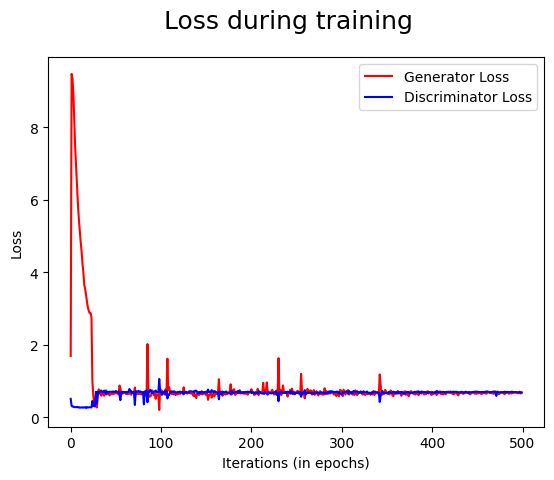

In [40]:
#Plot Loss Function
plt.suptitle('Loss during training', fontsize=18)
plt.plot(hist.history["g_loss"], 'r', label='Generator Loss')
plt.plot(hist.history["d_loss"], 'b', label='Discriminator Loss')
plt.xlabel("Iterations (in epochs)")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.show()

In [36]:
imgs = generator.predict(tf.random.normal((5, 128, 1)))

1/1 [==============================] - 0s 20ms/step


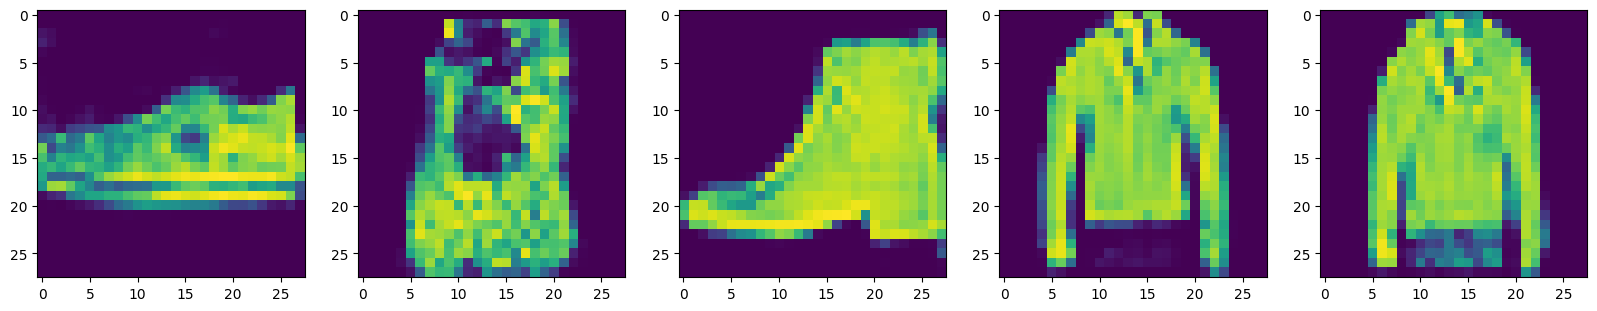

In [39]:
fig, axs = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    axs[i].imshow(imgs[i])